In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
from pandas.plotting import scatter_matrix
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/public_timeseries_testing_util.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/supplemental_clinical_data.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide/__init__.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/sample_submission.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_proteins.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_peptides.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test

In [2]:
train_proteins_df = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv')
print(train_proteins_df.shape)
print(train_proteins_df.memory_usage(deep=True).sum()/1024/1024, " MBs")
train_proteins_df.head(10)

(232741, 5)
33.64677047729492  MBs


,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.30
1,55_0,0,55,O00533,732430.00
2,55_0,0,55,O00584,39585.80
3,55_0,0,55,O14498,41526.90
4,55_0,0,55,O14773,31238.00
5,55_0,0,55,O14791,4202.71
6,55_0,0,55,O15240,177775.00
7,55_0,0,55,O15394,62898.20
8,55_0,0,55,O43505,333376.00
9,55_0,0,55,O60888,166850.00


In [3]:
train_peptides_df = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv')
print(train_peptides_df.shape)
print(train_peptides_df.memory_usage(deep=True).sum()/1024/1024, " MBs")
train_peptides_df.head(10)

(981834, 6)
212.76564979553223  MBs


,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7
5,55_0,0,55,O00533,TLKIENVSYQDKGNYR,23216.5
6,55_0,0,55,O00533,VIAVNEVGR,170878.0
7,55_0,0,55,O00533,VMTPAVYAPYDVK,148771.0
8,55_0,0,55,O00533,VNGSPVDNHPFAGDVVFPR,55202.1
9,55_0,0,55,O00584,ELDLNSVLLK,27229.3


In [4]:
pro_pep_join = pd.merge(train_proteins_df, train_peptides_df, on=['patient_id','visit_id','visit_month','UniProt'], how='inner')

del train_proteins_df, train_peptides_df
gc.collect()

42

In [5]:
train_clinical_data_df = pd.read_csv('/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv')
print(train_clinical_data_df.shape)
print(train_clinical_data_df.memory_usage(deep=True).sum()/1024/1024, " MBs")

full_training_data = pd.merge(pro_pep_join, train_clinical_data_df, on=['patient_id','visit_id','visit_month'], how='inner')

del pro_pep_join, train_clinical_data_df
gc.collect()

print(full_training_data.shape)
full_training_data.head(10)

(2615, 8)
0.3944511413574219  MBs
(941744, 12)


,visit_id,visit_month,patient_id,UniProt,NPX,Peptide,PeptideAbundance,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,0,55,O00391,11254.3,NEQEQPLGQWHLS,11254.3,10.0,6.0,15.0,NaN,NaN
1,55_0,0,55,O00533,732430.0,GNPEPTFSWTK,102060.0,10.0,6.0,15.0,NaN,NaN
2,55_0,0,55,O00533,732430.0,IEIPSSVQQVPTIIK,174185.0,10.0,6.0,15.0,NaN,NaN
3,55_0,0,55,O00533,732430.0,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9,10.0,6.0,15.0,NaN,NaN
4,55_0,0,55,O00533,732430.0,SMEQNGPGLEYR,30838.7,10.0,6.0,15.0,NaN,NaN
5,55_0,0,55,O00533,732430.0,TLKIENVSYQDKGNYR,23216.5,10.0,6.0,15.0,NaN,NaN
6,55_0,0,55,O00533,732430.0,VIAVNEVGR,170878.0,10.0,6.0,15.0,NaN,NaN
7,55_0,0,55,O00533,732430.0,VMTPAVYAPYDVK,148771.0,10.0,6.0,15.0,NaN,NaN
8,55_0,0,55,O00533,732430.0,VNGSPVDNHPFAGDVVFPR,55202.1,10.0,6.0,15.0,NaN,NaN
9,55_0,0,55,O00584,39585.8,ELDLNSVLLK,27229.3,10.0,6.0,15.0,NaN,NaN


In [6]:
temp_df = full_training_data.groupby(['patient_id']).agg(visit_month_per_patient=('visit_month', 'nunique'), UniProt_per_patient=('UniProt', 'nunique')
                                               , NPX_per_patient=('NPX', 'nunique'), Peptide_per_patient=('Peptide', 'nunique')
                                             ).reset_index(level=['patient_id'])
temp_df

,patient_id,visit_month_per_patient,UniProt_per_patient,NPX_per_patient,Peptide_per_patient
0,55,4,226,883,958
1,942,4,223,860,950
2,1517,4,226,878,947
3,1923,3,219,628,934
4,2660,4,223,855,944
...,...,...,...,...,...
243,63875,5,225,1088,947
244,63889,6,205,1069,876
245,64669,5,213,994,930
246,64674,6,221,1265,948


In [7]:
temp_df.visit_month_per_patient.unique()

array([4, 3, 5, 6, 7, 2, 8, 9, 1])

In [8]:
temp_df[(temp_df['visit_month_per_patient']==1) | (temp_df['visit_month_per_patient']==2)]

,patient_id,visit_month_per_patient,UniProt_per_patient,NPX_per_patient,Peptide_per_patient
20,7151,2,219,424,941
47,13968,2,217,419,942
48,14035,2,215,416,927
82,20791,2,225,436,944
96,24818,2,218,386,904
103,25911,2,216,419,926
132,33108,2,218,431,917
159,41617,2,219,426,945
163,41930,1,199,199,876
165,42086,2,220,427,918


In [9]:
full_training_data[full_training_data['patient_id']==41930]

,visit_id,visit_month,patient_id,UniProt,NPX,Peptide,PeptideAbundance,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
110576,41930_0,0,41930,O00533,158525.00,IEIPSSVQQVPTIIK,49563.90,9.0,7.0,16.0,5.0,Off
110577,41930_0,0,41930,O00533,158525.00,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,11216.70,9.0,7.0,16.0,5.0,Off
110578,41930_0,0,41930,O00533,158525.00,SMEQNGPGLEYR,6990.57,9.0,7.0,16.0,5.0,Off
110579,41930_0,0,41930,O00533,158525.00,VIAVNEVGR,31495.20,9.0,7.0,16.0,5.0,Off
110580,41930_0,0,41930,O00533,158525.00,VMTPAVYAPYDVK,43012.50,9.0,7.0,16.0,5.0,Off
...,...,...,...,...,...,...,...,...,...,...,...,...
111447,41930_0,0,41930,Q9UHG2,62335.00,ILAGSADSEGVAAPR,33612.20,9.0,7.0,16.0,5.0,Off
111448,41930_0,0,41930,Q9UNU6,14703.10,KNM(UniMod_35)FEFLK,14703.10,9.0,7.0,16.0,5.0,Off
111449,41930_0,0,41930,Q9Y646,7735.58,LALLVDTVGPR,7735.58,9.0,7.0,16.0,5.0,Off
111450,41930_0,0,41930,Q9Y6R7,33877.70,AGC(UniMod_4)VAESTAVC(UniMod_4)R,10439.00,9.0,7.0,16.0,5.0,Off


array([[<AxesSubplot:title={'center':'updrs_1'}>,
        <AxesSubplot:title={'center':'updrs_2'}>],
       [<AxesSubplot:title={'center':'updrs_3'}>,
        <AxesSubplot:title={'center':'updrs_4'}>]], dtype=object)

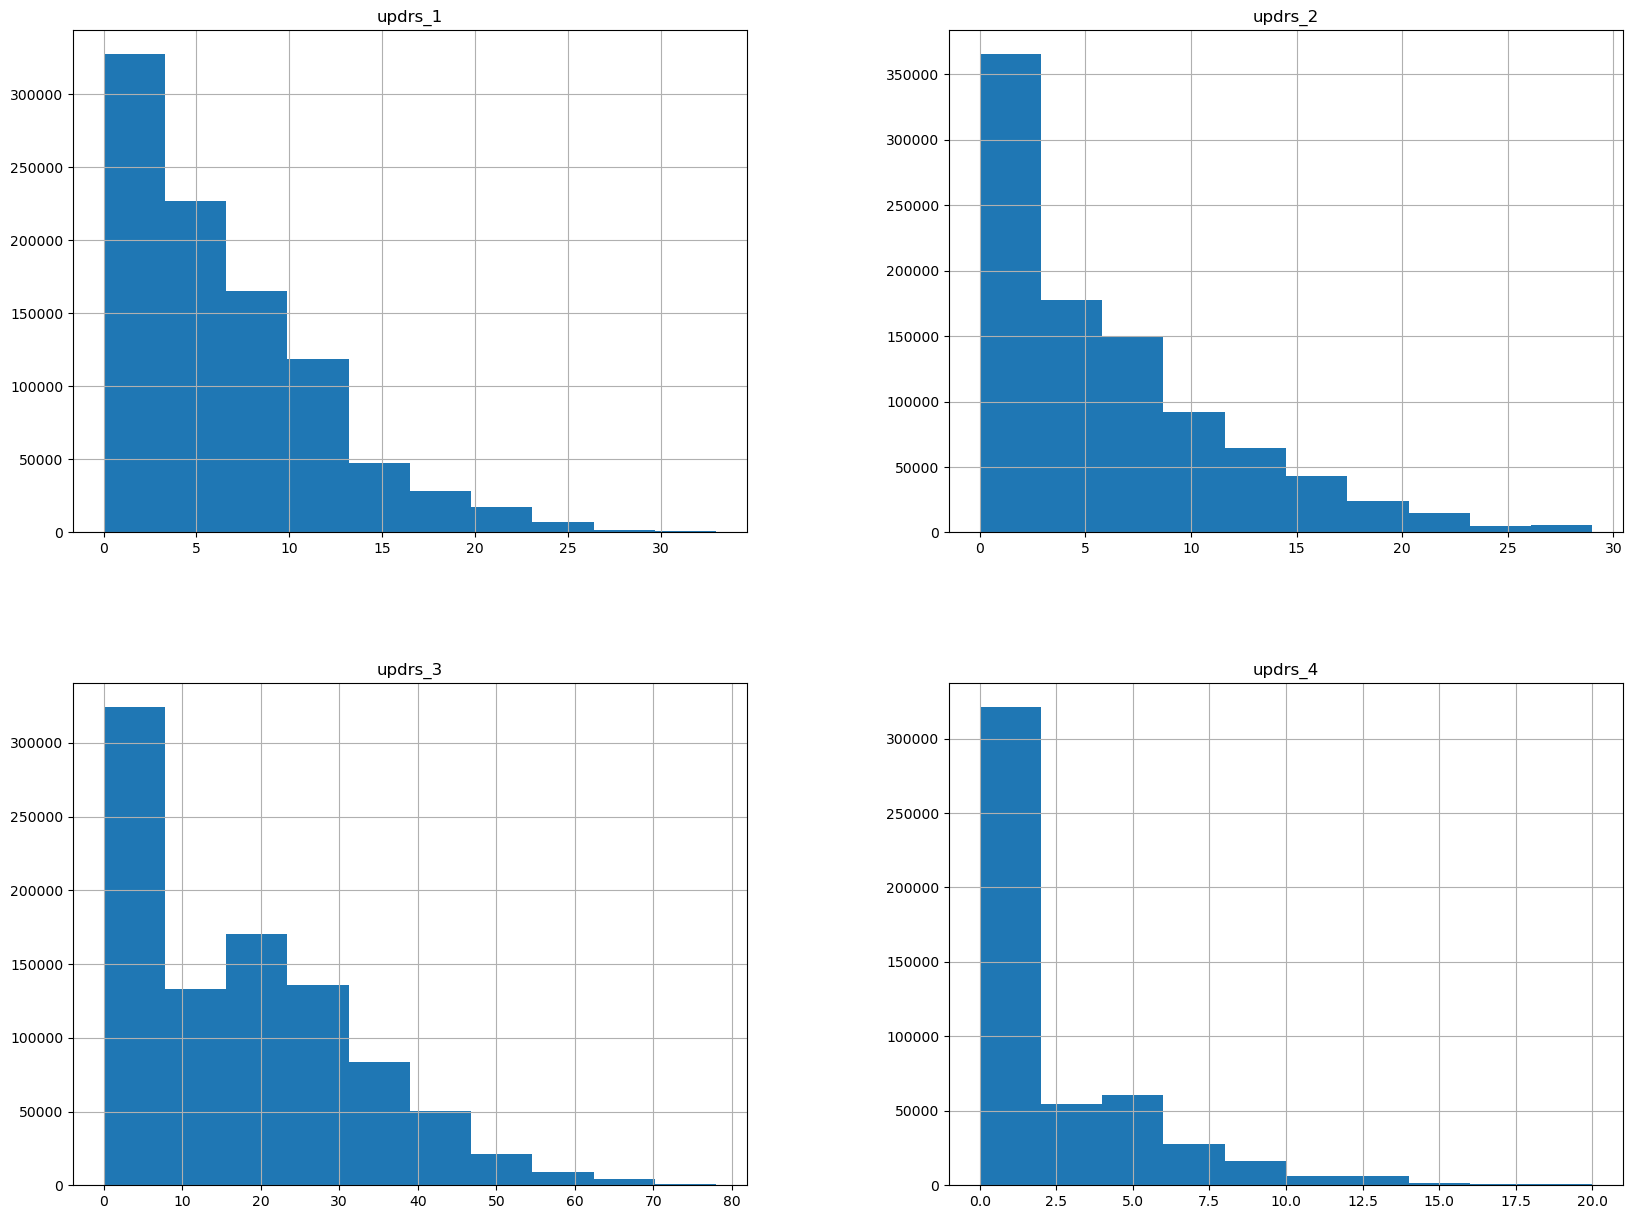

In [10]:
full_training_data[['updrs_1','updrs_2','updrs_3','updrs_4']].hist(figsize=(20,15))